In [1]:
import json
import os
import pickle
import sys

import numpy as np
from tqdm import tqdm

with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])

from sklearn.model_selection import train_test_split as tts
from utils.ipm import NeuronLoader
from utils.metrics import DescriminationConfidenceEstimator as DCE
from utils.utils import mkeqdata
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau

nmb_rep = 100

outPath = os.path.join(dirs['out']['rsa'])
os.makedirs(outPath, exist_ok=True)

In [2]:
def hist_equalize(matrix):
    matrix = np.copy(matrix)
    shape = matrix.shape
    matrix = matrix.reshape(-1)
    index = matrix.argsort()
    values = np.linspace(0, 1, index.shape[0])
    matrix[index] = values
    return matrix.reshape(shape)

def mkrdm(data):
    rdmat = 1 - cosine_similarity(data)
    return rdmat

def mkherdm(data):
    rdmat = 1 - cosine_similarity(data)
    return hist_equalize(rdmat)

In [3]:
monkey = "both"
selectivity = "fast"
data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

with open("../utils/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]

noneIndex = (info.cat == "none")
info = info[~noneIndex].reset_index(drop=True)
data.it = data.it[~noneIndex]
data.pfc = data.pfc[~noneIndex]

In [4]:
argsort = np.argsort(info.cat)
rdmItc = np.nan * np.ones([argsort.size, argsort.size, data.time.size])
rdmPfc = np.nan * np.ones([argsort.size, argsort.size, data.time.size])
# rdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])

herdmat = np.nan * np.ones([argsort.size, argsort.size, data.time.size])

for itime in range(data.time.size):
    rdmItc[:,:,itime] = mkrdm(data.it[argsort, :, itime])
    rdmPfc[:,:,itime] = mkrdm(data.pfc[argsort, :, itime])
    # herdmat[:,:,itime] = mkherdm(data.it[argsort, :, itime])

In [82]:
from statistics import NormalDist
from matplotlib import pyplot as plt

def rdmGranger(mdl, src, dst, n, k):
    i = np.triu_indices(src.shape[0], k=1)

    reducedR2, fullR2 = [], []
    for itime in np.arange(n+k, rdmItc.shape[2]):

        Y = dst[i[0], i[1], itime]
        X = dst[i[0], i[1], itime-n-k:itime-k]
        mdl = mdl.fit(X, Y)
        reducedR2.append(mdl.score(X, Y))

        X = np.concatenate((dst[i[0], i[1], itime-n-k:itime-k], src[i[0], i[1], itime-n-k:itime-k]), axis=-1)
        mdl = mdl.fit(X, Y)
        fullR2.append(mdl.score(X, Y))

    return np.array(reducedR2), np.array(fullR2)
# plt.imshow(X)
# plt.title(data.time[itime])
# plt.xticks(ticks=np.arange(1, 129, 10), labels=info.cat[argsort].to_numpy()[np.arange(1, 129, 10)], rotation=90);

In [95]:
from sklearn.linear_model import LinearRegression, Ridge

mdl = Ridge(fit_intercept=True, positive=False)
pfc2itcRR2, pfc2itcFR2 = rdmGranger(mdl, rdmPfc, rdmItc)
itc2pfcRR2, itc2pfcFR2 = rdmGranger(mdl, rdmItc, rdmPfc)

In [96]:
pfc2itcGi = np.log(np.array(pfc2itcFR2) / np.array(pfc2itcRR2))
itc2pfcGi = np.log(np.array(itc2pfcFR2) / np.array(itc2pfcRR2))

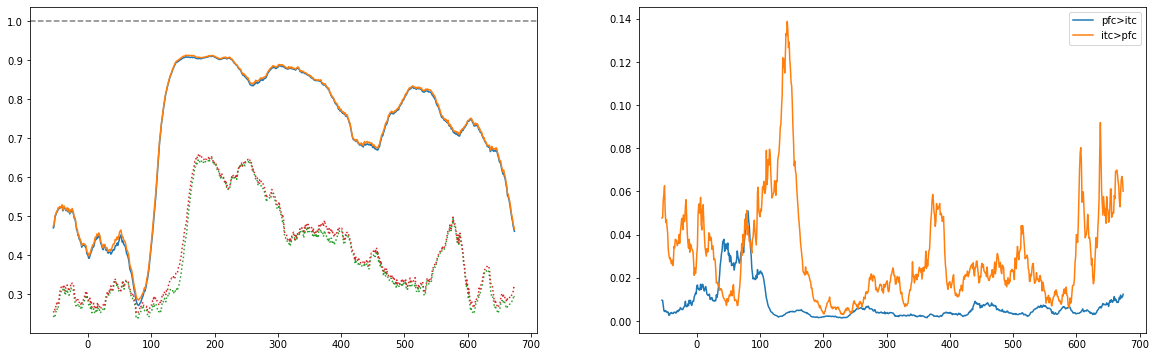

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
tim = np.arange(-175, 675, 1)
axs[0].plot(tim[120:], np.array(pfc2itcRR2))
axs[0].plot(tim[120:], np.array(pfc2itcFR2))
axs[0].plot(tim[120:], np.array(itc2pfcRR2), ls=':')
axs[0].plot(tim[120:], np.array(itc2pfcFR2), ls=':')
axs[0].axhline(1, c='gray', ls='--')

axs[1].plot(tim[120:], np.array(pfc2itcGi))
axs[1].plot(tim[120:], np.array(itc2pfcGi))
axs[1].legend(['pfc>itc', 'itc>pfc'])

In [32]:
X.shape

(8256, 100)

In [59]:
_tt = []
tt = []
for itime in range(data.time.size):
    for jtime in range(data.time.size):
        r = kendalltau(rdmItc[:, :, itime], rdmPfc[:, :, jtime])
        _tt.append(r)
    tt.append(_tt)
tt = np.array(tt)

In [1]:
tt

NameError: name 'tt' is not defined

In [ ]:
# region = "it"
# X = data.it if region=='it' else data.pfc
# y = grablabels(hierarchy='categories')

# img_index = np.arange(1, y.size+1)[np.argwhere(~np.isnan(y)).squeeze()]
# X = X[np.argwhere(~np.isnan(y)).squeeze()]
# y = y[np.argwhere(~np.isnan(y)).squeeze()]

# yc = np.full(y.size, 'xx')
# yc[y==0] = 'af'
# yc[y==1] = 'hf'
# yc[y==2] = 'mf'
# yc[y==3] = 'hb'
# yc[y==4] = 'mb'
# yc[y==5] = 'ab'
# yc[y==6] = 'xn'
# yc[y==7] = 'xa'

argsort = np.argsort(y)
rdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])
herdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])

for itime in range(X.shape[2]):
    rdmat[:,:,itime] = mkrdm(X[argsort, :, itime])
    herdmat[:,:,itime] = mkherdm(X[argsort, :, itime])